In [8]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from google.colab import drive
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
#Re-configuracion de rutas y dispositivo
drive.mount('/content/drive')

SAVE_DIR = '/content/drive/MyDrive/Master Thesis/Results'
os.makedirs(SAVE_DIR, exist_ok=True)
DATA_DIR = '/content/drive/MyDrive/Master Thesis/Data/Split_Dataset'
Save_Path = '/content/drive/MyDrive/Master Thesis/Models/vit_archivtecture_model.pth'

#Crear carpeta de modelos si no existe
os.makedirs(os.path.dirname(Save_Path), exist_ok=True)

#Configuracion de dispositivos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Ejectuando en: {device}")

Mounted at /content/drive
Ejectuando en: cuda


In [10]:
# 2. CARGA DE DATOS Y MODELO
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), val_transforms)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
num_classes = len(val_dataset.classes)
class_names = val_dataset.classes

print(f"Dataset de validacion Cargado. Clases: {num_classes}")

# Arquitectura con Hook para Atención
# 1. ARQUITECTURA CORREGIDA CON HOOK ROBUSTO
class ViTAttention(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Cargamos el modelo base
        self.model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
        self.model.heads.head = nn.Linear(self.model.heads.head.in_features, num_classes)
        self.att_weights = None

        # Registramos el hook en la capa de atención del último bloque del encoder
        # Usamos la capa de salida de la atención del bloque 11
        target_layer = self.model.encoder.layers.encoder_layer_11.self_attention
        target_layer.register_forward_hook(self._hook)

    def _hook(self, module, input, output):
        # En vit_b_16, el output de self_attention es un tuple o un tensor dependiendo de la implementación
        # Buscamos capturar la matriz de atención
        self.att_weights = output # Guardamos el output directamente

    def forward(self, x):
        return self.model(x)

Dataset de validacion Cargado. Clases: 14


In [11]:
# 2. FUNCIÓN DE PROCESAMIENTO ACTUALIZADA
def get_attention_overlay(img_tensor, att_weights):
    if att_weights is None:
        return None

    # CORRECCIÓN: Si att_weights es una tupla, extraemos el primer elemento
    if isinstance(att_weights, tuple):
        att_weights = att_weights[0]

    inv_norm = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
    img = inv_norm(img_tensor).permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)

    # Procesamiento del tensor: (Batch, Sequence_Length, Embedding_Dim)
    # 1. Saltamos el primer token (CLS) con 1:
    # 2. Promediamos las características con mean(dim=-1)
    # 3. Reorganizamos a 14x14 (que es el grid de ViT-B/16 para 224px)
    att_map = att_weights[0, 1:, :].mean(dim=-1).reshape(14, 14).cpu().detach().numpy()

    att_map = cv2.resize(att_map, (224, 224))
    att_map = (att_map - att_map.min()) / (att_map.max() - att_map.min() + 1e-8)

    heatmap = cv2.applyColorMap(np.uint8(255 * att_map), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    return (heatmap * 0.4 + img * 255 * 0.6).astype(np.uint8)

🎨 Generando comparativas de atención...


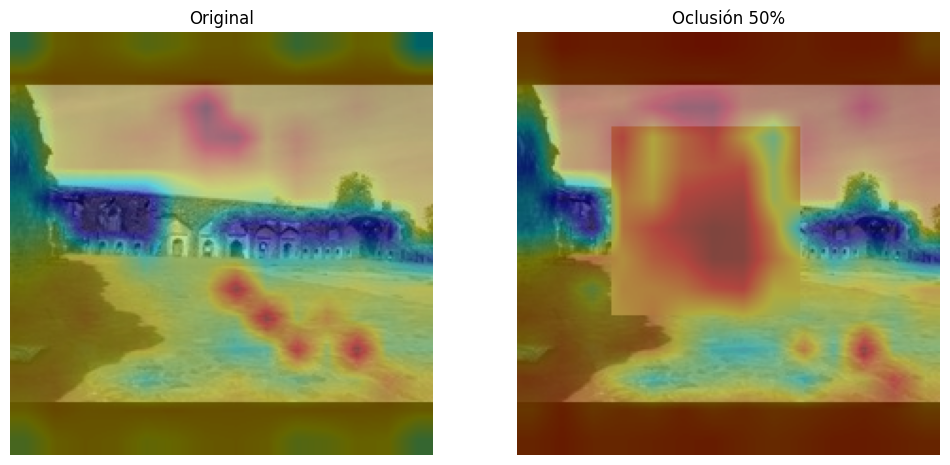

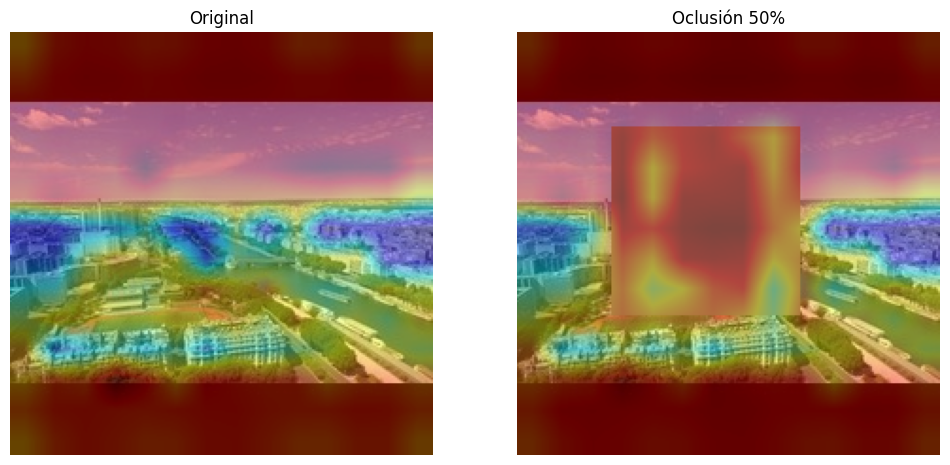

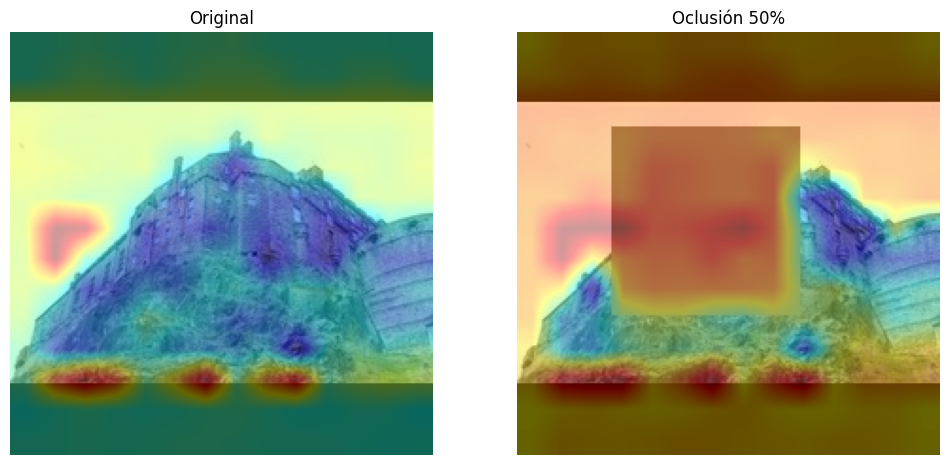

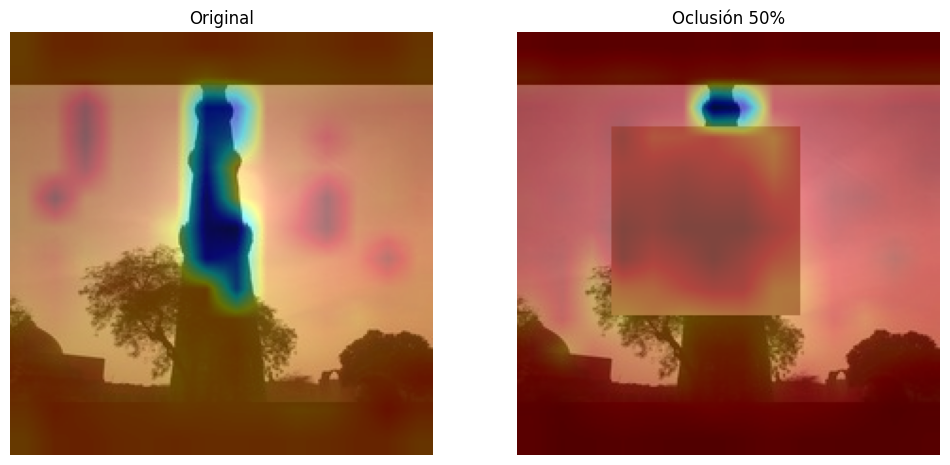

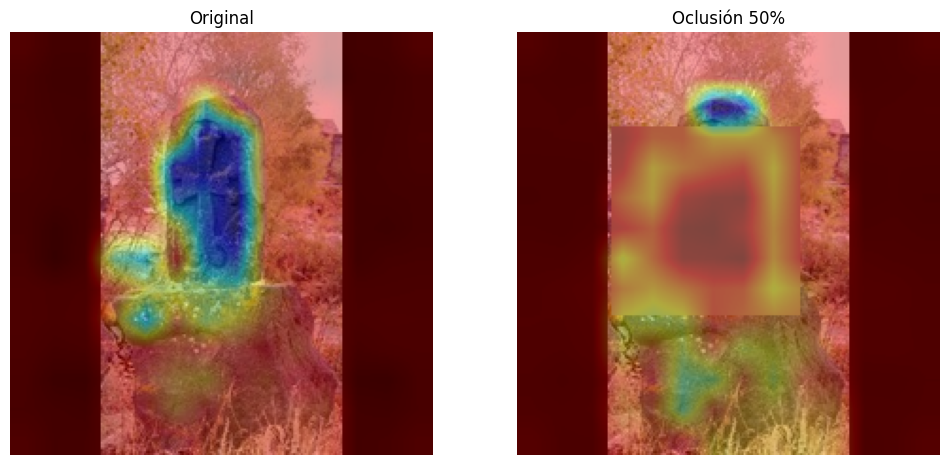

In [12]:
# 3. EJECUCIÓN CON VERIFICACIÓN
print("🎨 Generando comparativas de atención...")
model = ViTAttention(num_classes).to(device)
model.model.load_state_dict(torch.load(Save_Path))
model.eval()

for i, (inputs, labels) in enumerate(val_loader):
    if i >= 5: break

    inputs = inputs.to(device)

    # Caso A: Original
    _ = model(inputs)
    map_orig = get_attention_overlay(inputs[0], model.att_weights)

    if map_orig is None:
        print(f"⚠️ No se pudo capturar atención para la imagen {i}. Saltando...")
        continue

    # Caso B: Oclusión 50%
    inputs_occ = inputs.clone()
    inputs_occ[:, :, 50:150, 50:150] = 0
    _ = model(inputs_occ)
    map_occ = get_attention_overlay(inputs_occ[0], model.att_weights)

    # Plotting (El mismo código de antes)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(map_orig); ax[0].set_title(f"Original")
    ax[1].imshow(map_occ); ax[1].set_title("Oclusión 50%")
    for a in ax: a.axis('off')
    plt.show()

⌛ Generando predicciones para oclusión al 50.0%...


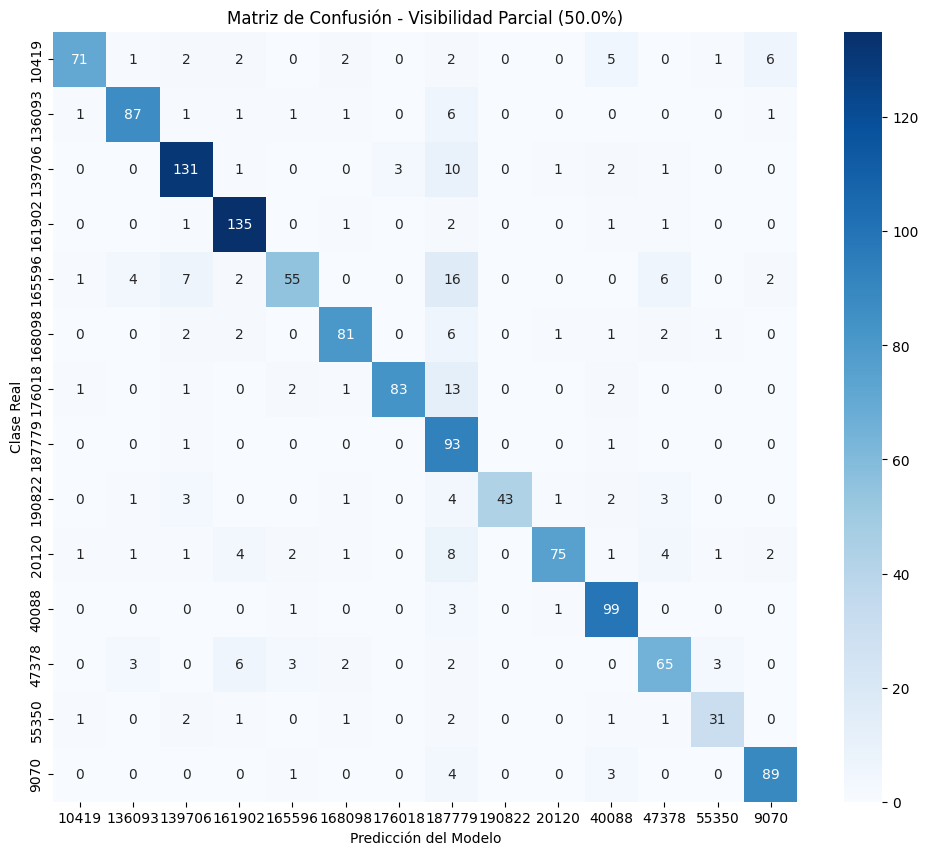


📝 Reporte de Clasificación:
              precision    recall  f1-score   support

       10419       0.93      0.77      0.85        92
      136093       0.90      0.88      0.89        99
      139706       0.86      0.88      0.87       149
      161902       0.88      0.96      0.92       141
      165596       0.85      0.59      0.70        93
      168098       0.89      0.84      0.87        96
      176018       0.97      0.81      0.88       103
      187779       0.54      0.98      0.70        95
      190822       1.00      0.74      0.85        58
       20120       0.95      0.74      0.83       101
       40088       0.84      0.95      0.89       104
       47378       0.78      0.77      0.78        84
       55350       0.84      0.78      0.81        40
        9070       0.89      0.92      0.90        97

    accuracy                           0.84      1352
   macro avg       0.87      0.83      0.84      1352
weighted avg       0.86      0.84      0.84      13

In [13]:
def generar_matriz_confusion(nivel_oclusion=0.5):
    y_true = []
    y_pred = []

    model.eval()
    print(f"⌛ Generando predicciones para oclusión al {nivel_oclusion*100}%...")

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)

            # Aplicar oclusión si es necesario
            if nivel_oclusion > 0:
                # Usamos el mismo parche central del script anterior
                inputs[:, :, 50:150, 50:150] = 0

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Crear la matriz
    cm = confusion_matrix(y_true, y_pred)

    # Visualización
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicción del Modelo')
    plt.ylabel('Clase Real')
    plt.title(f'Matriz de Confusión - Visibilidad Parcial ({nivel_oclusion*100}%)')

    # Guardar en Drive
    plt.savefig(f"{SAVE_DIR}/matriz_confusion_{int(nivel_oclusion*100)}.png")
    plt.show()

    # Imprimir reporte métrico (Precisión, Recall, F1-Score)
    print("\n📝 Reporte de Clasificación:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Ejecutar para el caso más crítico
generar_matriz_confusion(nivel_oclusion=0.5)